In [1]:
import pandas as pd
import numpy as np
import os
import pickle
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
import re

In [39]:
df = pd.read_csv("Assassin1.csv")

In [3]:
# 1. Check for NaNs in the processed text
num_nans = df['final_text'].isnull().sum()
print("NaNs in final_text:", num_nans)

# 2. Check for empty strings (after stripping whitespace)
num_empty = (df['final_text'].str.strip() == '').sum()
print("Empty strings in final_text:", num_empty)


NaNs in final_text: 0
Empty strings in final_text: 0


In [4]:
df = df.dropna(subset=['final_text']) # Drop rows that are NaN
df = df.reset_index(drop=True)


In [5]:
print(df.isnull().sum())


is_spam       0
final_text    0
dtype: int64


## Data Engineering/Extraction

### TF-IDF Vectorization

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=5000,    # limit vocabulary size, 5000 features (these features are the most “important” words or n-grams from our corpus)
    ngram_range=(1, 2),   # unigrams + bigrams
    stop_words='english'  # skip common words
)

X_tfidf = tfidf.fit_transform(df['final_text'].fillna(''))
 #feature matrix, the numerical representation of all our documents


TF-IDF extracts each unique word (or n-gram), builds a vocabulary

Builds/returns a vocabulary of all unique words (or n-grams) it learned from your corpus. Above shows only the words that actually appear in the first email, along with their importance scores.

### Inspect / Analyze TF-IDF

In [7]:
vocab = tfidf.get_feature_names_out()
print(len(vocab))        # should be ≤ max_features
print(vocab[:20])        # preview first 20 words

5000
['00' '00 00' '00 avg' '00 http' '00 second' '000' '000 gorilla' '0000'
 '0000 00' '000000' '000000000' '01' '01 32' '01 35' '01 40' '01 anthrax'
 '01 blake' '01 brangelina' '01 campaign' '01 canada']


In [8]:
# View words specifically 
word_vocab = [w for w in vocab if re.match(r'^[a-zA-Z]+$', w)]
print(f"Words only: {len(word_vocab)}")
print(word_vocab[:50])  # preview first 50 words


Words only: 3030
['aa', 'aaai', 'aaron', 'ab', 'ability', 'able', 'absolutely', 'abstract', 'absurd', 'abuse', 'ac', 'academic', 'academy', 'accept', 'acceptance', 'accepted', 'access', 'according', 'account', 'achieve', 'achieved', 'acm', 'acpi', 'acpid', 'act', 'action', 'active', 'activity', 'actual', 'actually', 'acy', 'ad', 'adam', 'adaptive', 'add', 'added', 'adding', 'addition', 'additional', 'address', 'admin', 'administration', 'administrator', 'adobe', 'advance', 'advanced', 'advantage', 'advertise', 'advertisement', 'advertiser']


Above checks TF-IDF vocabulary

In [9]:
i = 0  # first email
df_single = pd.DataFrame(X_tfidf[i].T.todense(), index=tfidf.get_feature_names_out(), columns=["tfidf"])
print(df_single[df_single.tfidf > 0]) #Filter to only non-zero TF-IDF scores


              tfidf
able       0.275843
caused     0.390255
com        0.092886
come       0.257070
dimension  0.381227
http       0.092971
small      0.305079
soon       0.310710
street     0.323654
sure       0.258499
trouble    0.356809
woman      0.233283


In [10]:
sparsity = 1.0 - (X_tfidf.count_nonzero() / (X_tfidf.shape[0] * X_tfidf.shape[1]))
print(f"Sparsity: {sparsity:.2%}")


Sparsity: 98.19%


### top words by TF-IDF score

In [11]:
# tfidf (TfidfVectorizer) and X_tfidf assumed present
feature_names = tfidf.get_feature_names_out()
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=feature_names)

# average TF-IDF in spam vs non-spam
avg_spam = tfidf_df[df['is_spam'] == 1].mean(axis=0)
avg_nonspam = tfidf_df[df['is_spam'] == 0].mean(axis=0)

spam_top = avg_spam.sort_values(ascending=False).head(40)
print("Top TF-IDF words in spam (avg):")
print(spam_top)


Top TF-IDF words in spam (avg):
com                  0.070072
cnn                  0.065304
http                 0.060903
watch                0.047659
cnn com              0.045311
replica              0.044912
http www             0.040869
www                  0.039931
index html           0.036903
video                0.036170
www cnn              0.035522
index                0.035208
html                 0.033963
2008                 0.031498
alert                0.031377
08                   0.025610
replica watch        0.022829
email                0.021030
love                 0.020572
click                0.017760
com video            0.016973
url                  0.016892
custom               0.016301
health               0.015928
2008 08              0.015809
video partners       0.015465
url video            0.015465
partners             0.015461
html url             0.015459
partners email       0.015449
email index          0.015449
com 2008             0.015199
rolex   

## Additional features (to test)

- Common keywords
- word count
- unique word count
- number frequency 

### Exploring common phishing keywords

In [12]:
key_words = [
    'click', 'login', 'transfer', 'free', 'win', 'payment', 'transaction', 'transfer', 'money', 'tax', 'receipt',
    'urgent', 'verify account', 'act', 'confirm', 'view', 'unusual', "limited", 
    "new", "message", "required", "action", "document", "verification","special", "offer"

]

# Dictionary to hold keyword summary
kw_summary = {}

# Loop through each keyword
for w in key_words:
    # Detect presence of keyword (boolean Series, not added to df)
    has_kw = df['final_text'].str.contains(r'\b' + re.escape(w) + r'\b', regex=True, case=False)
    
    # Compute metrics
    tp = ((has_kw) & (df['is_spam'] == 1)).sum()  # spam emails containing keyword
    fp = ((has_kw) & (df['is_spam'] == 0)).sum()  # non-spam emails containing keyword
    in_email = has_kw.sum()                       # total emails containing keyword

    # Store in summary
    kw_summary[w] = {
        'in_email': in_email,
        'spam_hits': tp,
        'nonspam_hits': fp,
        'spam_likelihood': tp / (in_email + 1e-9)
    }

# Convert to DataFrame for viewing
kw_df = pd.DataFrame.from_dict(kw_summary, orient='index').sort_values('spam_likelihood', ascending=False)
kw_df

spam_likelihood_dict = kw_df['spam_likelihood'].to_dict()

def keyword_likelihood_score(text):
    score = 0
    for kw, likelihood in spam_likelihood_dict.items():
        if re.search(r'\b' + re.escape(kw) + r'\b', text, flags=re.IGNORECASE):
            score += likelihood
    return score

# Add feature to DF
df['kw_score'] = df['final_text'].apply(keyword_likelihood_score)



In [13]:
df.sample(10)

,is_spam,final_text,kw_score
15340,1,good health goal . top news male health ! equi...,0.000000
3389,0,hi dad 3 monthly check hospital appointment ye...,0.000000
34239,1,cnn alert : custom alert alert name : custom a...,1.185569
37211,0,"18/11/2007 , dominic dunlop wrote : > suggest ...",0.000000
38262,0,'m sure understand problem exactly . one pas c...,0.000000
32265,1,hear gf scream get stuck deep immeasurable lov...,0.129032
19498,1,"actually cut bill half ; literally , did't eve...",0.000000
26463,0,"cnet | digital dispatch february 21 , 2008 vie...",1.874071
37249,0,http : //issues.apache.org/spamassassin/show_b...,0.436170
15483,0,'s bad actually ....,0.000000


In [14]:
import string
import re

df['word_count'] = df['final_text'].apply(lambda x: len(str(x).split()))
df['unique_word_count'] = df['final_text'].apply(lambda x: len(set(str(x).split())))

def count_numbers(text):
    return len(re.findall(r'\d+', text))

df['num_count'] = df['final_text'].apply(count_numbers)


def repeated_punct_symbols(text, min_repeat=2):
    text = str(text)
    # Define suspicious symbols (can adjust based on dataset)
    suspicious_chars = string.punctuation  # includes all standard punctuation
    # You could also customize like: "!$%#*?@"
    
    # Regex: any character in suspicious_chars repeated min_repeat or more times
    pattern = r'([{}])\1{{{}}}'.format(re.escape(suspicious_chars), min_repeat - 1)
    
    # Return 1 if any repeated pattern found, else 0
    return int(bool(re.search(pattern, text)))

In [15]:
df.sample(10)

,is_spam,final_text,kw_score,word_count,unique_word_count,num_count
1575,0,something come spam link form : http : //url/o...,0.000000,42,35,0
29257,1,sell premium watch . 's battery replica like r...,0.000000,28,21,0
11179,0,"friday 15 february 2008 09:29 , aaron kulkis w...",0.000000,79,48,4
20307,1,get generic analog price much lower without ex...,1.041457,35,30,1
27477,1,watch extravagant people replica classic rolex...,0.685413,18,16,1
28085,1,p xta en zq e lfu nla ne rgem yxq ent form npg...,0.685413,176,142,2
34449,1,prescription data used judge consumer http : /...,0.000000,8,8,0
4665,1,got something tell ! fist-rate experience bed ...,0.000000,60,46,6
3643,0,[ please cc response ] wondering getpass could...,0.409068,238,120,5
21137,1,clutching taking clothes bedroom ? 'll help re...,0.000000,44,39,1


### Unsual/rare word feature 
- signal for unusual or suspicious words

In [16]:
from collections import Counter

all_words = " ".join(df['final_text']).split()  # Use your cleaned text column

# Count the frequency of each word
word_counts = Counter(all_words)

# Define and store rare words (appearing < n times across your entire corpus) 
rare_words = {w for w, c in word_counts.items() if c < 4}

# Function to count rare words per email
def count_rare_words(text):
    return sum(1 for w in str(text).split() if w in rare_words)

df['rare_word_count'] = df['final_text'].apply(count_rare_words)


In [17]:
df['num_urls'] = df['final_text'].str.count(r'http[s]?://')
df['num_emails'] = df['final_text'].str.count(r'\b[\w.-]+@[\w.-]+\.\w+\b')

threshold = 4
df['many_rare_words'] = (df['rare_word_count'] >= threshold).astype(int)


In [18]:
df.sample(10)

,is_spam,final_text,kw_score,word_count,unique_word_count,num_count,rare_word_count,num_urls,num_emails,many_rare_words
6768,0,"sun , mar 2 , 2008 6:33 pm , brett cannon wrot...",0.333699,196,103,21,3,0,0,0
20444,0,trent nelson schrieb : > think holding develop...,0.000000,116,82,10,0,0,0,0
14926,0,-- -- -begin pgp signed message -- -- - hash :...,0.027102,181,101,28,8,0,0,1
31256,1,"rolex , patek philippe , omega , cartier , bvl...",1.010358,33,26,2,0,0,0,0
19937,1,want called macho ? http : //xl.cybermeded.com,0.000000,7,7,0,1,0,0,0
3793,1,study show woman hate men low libido http : //...,0.000000,10,10,0,0,0,0,0
9336,0,regular pygta meeting occurring pycon sprint ....,0.000000,93,63,1,5,0,0,1
32112,0,lars hecking wrote : > > > dump entire content...,0.000000,61,42,4,0,0,0,0
552,1,> +=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=...,0.928846,345,185,106,1,0,0,0
26956,0,"hi tim & , tue , apr 15 , 2008 3:20 pm , tim g...",0.302600,521,223,22,14,0,0,1


## Training

In [40]:
df['is_spam'].value_counts(normalize=True) * 100 #percent dsitrubution

is_spam
0    70.30998
1    29.69002
Name: proportion, dtype: float64

In [19]:
numeric_features = ['kw_score', 'word_count', 'unique_word_count','rare_word_count']
X_numeric = df[numeric_features]  # shape: (n_samples, n_numeric_features)

In [20]:
from scipy.sparse import hstack, csr_matrix
from sklearn.preprocessing import MaxAbsScaler

# Convert numeric features to sparse
X_numeric_sparse = csr_matrix(X_numeric.values)

# Scale numeric features
scaler = MaxAbsScaler()
X_numeric_scaled = scaler.fit_transform(X_numeric_sparse)

# Combine TF-IDF (sparse) and numeric (now scaled & sparse)
X_combined = hstack([X_tfidf, X_numeric_scaled])

print(X_combined.shape)  # (n_samples, n_tfidf_features + n_numeric_features)


(38669, 5004)


## Logistic Regression

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

y = df['is_spam']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, random_state=42, stratify=y
)

# Initialize Logistic Regression
model = LogisticRegression(
    solver='saga', 
    max_iter=5000, 
    penalty='l2',
)

# Fit model
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.9910783553141971

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      3368
           1       0.99      0.99      0.99      4366

    accuracy                           0.99      7734
   macro avg       0.99      0.99      0.99      7734
weighted avg       0.99      0.99      0.99      7734



In [22]:
train_set = accuracy_score(y_train, model.predict(X_train))
test_set = accuracy_score(y_test, model.predict(X_test))

print("Train accuracy:", train_set)
print("Test set acc:",  test_set)

Train accuracy: 0.9946985614999192
Test set acc: 0.9910783553141971


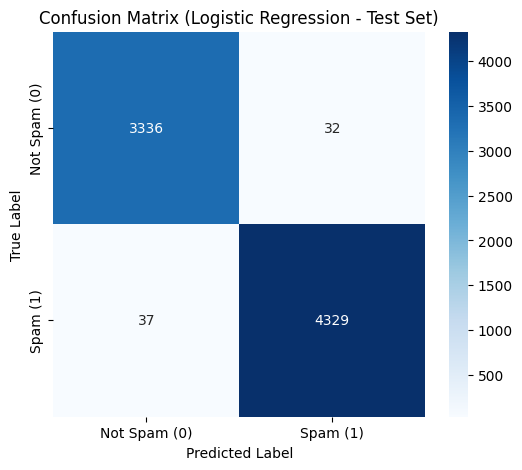

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Spam (0)', 'Spam (1)'],  
            yticklabels=['Not Spam (0)', 'Spam (1)'])
plt.title('Confusion Matrix (Logistic Regression - Test Set)')     
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


### Cross-Validation Check

In [24]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model, X_combined, y, cv=cv, scoring='accuracy')

print("Cross-validation accuracies:", scores)
print("Mean accuracy: {:.4f} ± {:.4f}".format(scores.mean(), scores.std()))


Cross-validation accuracies: [0.99146625 0.99224205 0.99159555 0.99301784 0.99275831]
Mean accuracy: 0.9922 ± 0.0006


## Naive Bayes

In [25]:
from sklearn.naive_bayes import MultinomialNB

nb_model = MultinomialNB()

nb_model.fit(X_train, y_train)
y_pred = nb_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nNaive Bayes Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9650892164468581

Naive Bayes Report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96      3368
           1       1.00      0.94      0.97      4366

    accuracy                           0.97      7734
   macro avg       0.96      0.97      0.96      7734
weighted avg       0.97      0.97      0.97      7734



In [26]:
# Cross validation check
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(nb_model, X_combined, y, cv=cv, scoring='accuracy')

print("Naive Bayes cross-val accuracies:", scores)
print("Mean accuracy: {:.4f} ± {:.4f}".format(scores.mean(), scores.std()))

Naive Bayes cross-val accuracies: [0.96586501 0.97207137 0.96470132 0.96689941 0.9690935 ]
Mean accuracy: 0.9677 ± 0.0026


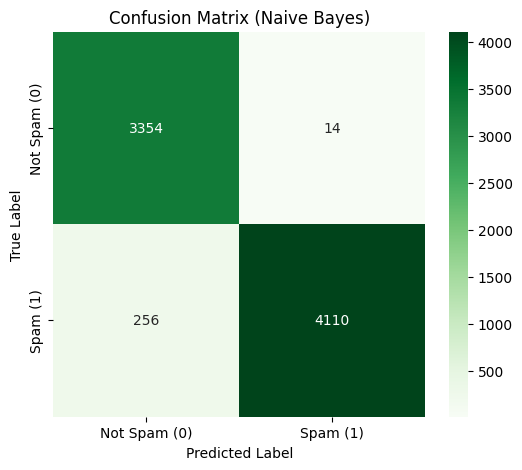

In [27]:
cm_nb = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_nb,
    annot=True,
    fmt='d',
    cmap='Greens',
    xticklabels=['Not Spam (0)', 'Spam (1)'],
    yticklabels=['Not Spam (0)', 'Spam (1)']
)
plt.title('Confusion Matrix (Naive Bayes)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## SVM Model

In [28]:
from sklearn.svm import LinearSVC

svm_model = LinearSVC(random_state=42)

svm_model.fit(X_train, y_train)

y_pred_svm = svm_model.predict(X_test)

print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("\nSVM Classification Report:\n", classification_report(y_test, y_pred_svm))

SVM Accuracy: 0.9923713472976468

SVM Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      3368
           1       0.99      0.99      0.99      4366

    accuracy                           0.99      7734
   macro avg       0.99      0.99      0.99      7734
weighted avg       0.99      0.99      0.99      7734



In [29]:
train_set = accuracy_score(y_train, svm_model.predict(X_train))
test_set = accuracy_score(y_test, svm_model.predict(X_test))

print("Train accuracy:", train_set)
print("Test set acc:",  test_set)

Train accuracy: 0.9992241797316955
Test set acc: 0.9923713472976468


In [30]:
# Cross validation check
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(svm_model, X_combined, y, cv=cv, scoring='accuracy')

print("SVM cross-val accuracies:", scores)
print("Mean accuracy: {:.4f} ± {:.4f}".format(scores.mean(), scores.std()))

SVM cross-val accuracies: [0.99392294 0.99418154 0.99418154 0.99482803 0.99573257]
Mean accuracy: 0.9946 ± 0.0007


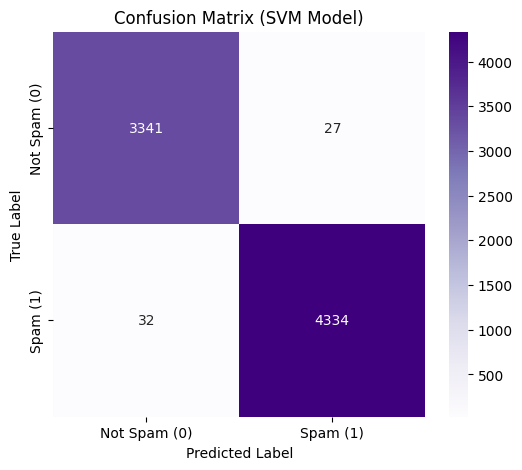

In [31]:
cm_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Purples',
            xticklabels=['Not Spam (0)', 'Spam (1)'],
            yticklabels=['Not Spam (0)', 'Spam (1)'])
plt.title('Confusion Matrix (SVM Model)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Random Forest

In [32]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Fit model
rf_model.fit(X_train, y_train)

# Predict
y_pred_rf = rf_model.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))


Accuracy: 0.9921127489009568

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      3368
           1       0.99      0.99      0.99      4366

    accuracy                           0.99      7734
   macro avg       0.99      0.99      0.99      7734
weighted avg       0.99      0.99      0.99      7734



In [33]:
# Cross validation check
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(rf_model, X_combined, y, cv=cv, scoring='accuracy')

print("Naive Bayes cross-val accuracies:", scores)
print("Mean accuracy: {:.4f} ± {:.4f}".format(scores.mean(), scores.std()))

Naive Bayes cross-val accuracies: [0.99405224 0.99301784 0.99172485 0.99159555 0.99392215]
Mean accuracy: 0.9929 ± 0.0010


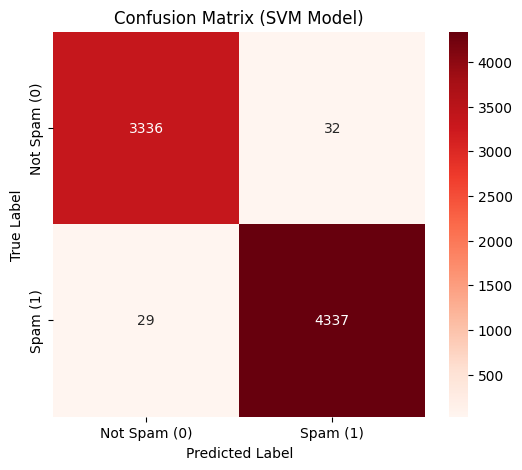

In [34]:
cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Reds',
            xticklabels=['Not Spam (0)', 'Spam (1)'],
            yticklabels=['Not Spam (0)', 'Spam (1)'])
plt.title('Confusion Matrix (SVM Model)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Slow comapred to other algorithms

## LGBM

In [35]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report

lgbm_model = LGBMClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=-1,          # -1 = no limit
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

lgbm_model.fit(X_train, y_train)

y_pred_lgbm = lgbm_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_lgbm))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lgbm))


[LightGBM] [Info] Number of positive: 17461, number of negative: 13474
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.185919 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 404579
[LightGBM] [Info] Number of data points in the train set: 30935, number of used features: 4805
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.564442 -> initscore=0.259208
[LightGBM] [Info] Start training from score 0.259208
Accuracy: 0.9934057408844065

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      3368
           1       0.99      0.99      0.99      4366

    accuracy                           0.99      7734
   macro avg       0.99      0.99      0.99      7734
weighted avg       0.99      0.99      0.99      7734



c:\Users\lle34\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [36]:
# Cross validation check
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(lgbm_model, X_combined, y, cv=cv, scoring='accuracy')

print("Naive Bayes cross-val accuracies:", scores)
print("Mean accuracy: {:.4f} ± {:.4f}".format(scores.mean(), scores.std()))

[LightGBM] [Info] Number of positive: 17461, number of negative: 13474
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.151350 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 404673
[LightGBM] [Info] Number of data points in the train set: 30935, number of used features: 4810
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.564442 -> initscore=0.259208
[LightGBM] [Info] Start training from score 0.259208


c:\Users\lle34\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 17461, number of negative: 13474
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.141900 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 404681
[LightGBM] [Info] Number of data points in the train set: 30935, number of used features: 4818
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.564442 -> initscore=0.259208
[LightGBM] [Info] Start training from score 0.259208


c:\Users\lle34\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 17462, number of negative: 13473
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.142924 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 406984
[LightGBM] [Info] Number of data points in the train set: 30935, number of used features: 4813
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.564474 -> initscore=0.259339
[LightGBM] [Info] Start training from score 0.259339


c:\Users\lle34\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 17462, number of negative: 13473
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.137621 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 404949
[LightGBM] [Info] Number of data points in the train set: 30935, number of used features: 4812
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.564474 -> initscore=0.259339
[LightGBM] [Info] Start training from score 0.259339


c:\Users\lle34\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 17462, number of negative: 13474
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.144260 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 403722
[LightGBM] [Info] Number of data points in the train set: 30936, number of used features: 4811
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.564456 -> initscore=0.259265
[LightGBM] [Info] Start training from score 0.259265
Naive Bayes cross-val accuracies: [0.99495733 0.99431084 0.99392294 0.99379364 0.99599121]
Mean accuracy: 0.9946 ± 0.0008


c:\Users\lle34\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


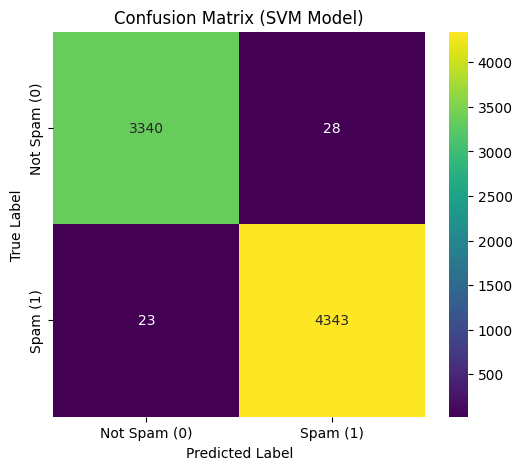

In [37]:
cm_lgbm = confusion_matrix(y_test, y_pred_lgbm)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_lgbm, annot=True, fmt='d', cmap='viridis',
            xticklabels=['Not Spam (0)', 'Spam (1)'],
            yticklabels=['Not Spam (0)', 'Spam (1)'])
plt.title('Confusion Matrix (SVM Model)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()